### 1. Libraries and basic setup

In this cell, I install and import all the Python libraries I will use in the project.  
- `kagglehub` is used to download the NBA dataset directly from Kaggle.  
- `pandas` and `numpy` are for data manipulation.  
- `scipy.stats` is for hypothesis testing.  
- `matplotlib` and `seaborn` are for visualizations.  
I also set a display option so that pandas shows more columns when printing data frames.


In [3]:
!pip install kagglehub --quiet

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

pd.set_option('display.max_columns', 50)


### 2. Download NBA dataset from Kaggle

Here I download the NBA games dataset using `kagglehub.dataset_download`.  
The function returns a folder path where all the CSV files are stored.  
I print this path and list the files inside it to verify that the dataset has been downloaded correctly (`games.csv`, `games_details.csv`, `players.csv`, `teams.csv`, `ranking.csv`).


In [4]:
path = kagglehub.dataset_download("nathanlauga/nba-games")

print("Dataset path:", path)

import os
print("Files in that folder:", os.listdir(path))


Using Colab cache for faster access to the 'nba-games' dataset.
Dataset path: /kaggle/input/nba-games
Files in that folder: ['players.csv', 'teams.csv', 'ranking.csv', 'games_details.csv', 'games.csv']


### 3. Load CSV files into pandas DataFrames

In this cell I read the main CSV files into pandas DataFrames:
- `games` contains game-level statistics and final results.
- `games_details` contains player-level box score statistics for each game.
- `players`, `teams`, and `ranking` are additional metadata tables (not heavily used yet).
At the end I print the shapes of `games` and `games_details` to confirm that the data loaded successfully.


In [5]:
games = pd.read_csv(os.path.join(path, "games.csv"))
games_details = pd.read_csv(os.path.join(path, "games_details.csv"))
players = pd.read_csv(os.path.join(path, "players.csv"))
teams = pd.read_csv(os.path.join(path, "teams.csv"))
ranking = pd.read_csv(os.path.join(path, "ranking.csv"))

games.shape, games_details.shape


/tmp/ipython-input-4047788856.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  games_details = pd.read_csv(os.path.join(path, "games_details.csv"))


((26651, 21), (668628, 29))

### 4. Basic data cleaning and preprocessing

This cell performs initial cleaning steps:

1. Convert the game date column `GAME_DATE_EST` to a proper datetime type.  
2. (Optional) Filter to seasons from 2010 onward to focus on more recent years.  
3. Convert the minutes played in `games_details` from a `"MM:SS"` string to a numeric value in minutes (`MIN_float`).  
4. Keep only rows where the player actually played more than 0 minutes.

After these steps, both `games` and `games_details` are cleaner and ready for analysis.


In [19]:
games.head()
games_details.head()
games['GAME_DATE_EST'] = pd.to_datetime(games['GAME_DATE_EST'])

games = games[games['SEASON'] >= 2010].copy()

def parse_minutes(min_str):
    if pd.isna(min_str):
        return np.nan
    try:
        m, s = str(min_str).split(':')
        return int(m) + int(s) / 60.0
    except ValueError:
        return np.nan

games_details['MIN_float'] = games_details['MIN'].apply(parse_minutes)

games_details = games_details[games_details['MIN_float'] > 0].copy()

games.shape, games_details.shape


((16793, 21), (534698, 30))

### 5. Define star players and subset their game data

Here I define a list of well-known star players (LeBron James, Stephen Curry, Kevin Durant, James Harden, Nikola Jokic).  
Using this list, I filter `games_details` to keep only the rows where one of these players appears.  
The result `star_details` contains the box score statistics for the selected star players in each game.


In [7]:
star_players = [
    "LeBron James",
    "Stephen Curry",
    "Kevin Durant",
    "James Harden",
    "Nikola Jokic"
]

star_details = games_details[games_details['PLAYER_NAME'].isin(star_players)].copy()
star_details[['PLAYER_NAME', 'TEAM_ABBREVIATION', 'GAME_ID', 'PTS', 'AST', 'REB']].head()


,PLAYER_NAME,TEAM_ABBREVIATION,GAME_ID,PTS,AST,REB
94,James Harden,PHI,22200467,15.0,8.0,2.0
164,Kevin Durant,BKN,22200470,23.0,5.0,7.0
276,LeBron James,LAL,22200475,31.0,11.0,6.0
488,James Harden,PHI,22200453,14.0,8.0,7.0
722,Kevin Durant,BKN,22200447,43.0,2.0,6.0


### 6. Build star-game dataset with team results and impact features

In this cell I link each star player’s performance to the corresponding game outcome:

1. From `games`, I keep only the relevant game-level columns (scores, rebounds, assists, and win flag).  
2. I merge `star_details` with this game information using `GAME_ID`.  
3. I determine whether the star’s team is the home team (`is_home`).  
4. From the home/away statistics, I compute the star’s team points, assists, and rebounds from the correct side.  
5. I calculate the point differential from the star team’s perspective.  
6. I create `star_team_win`, which is 1 if the star’s team won and 0 otherwise.  
7. I compute `pts_share`, the fraction of the team’s total points scored by the star.

The resulting `star_games` DataFrame is the main dataset for the analysis of star player impact.


In [8]:
games_small = games[[
    'GAME_ID', 'GAME_DATE_EST', 'SEASON',
    'HOME_TEAM_ID', 'VISITOR_TEAM_ID',
    'PTS_home', 'PTS_away',
    'AST_home', 'AST_away',
    'REB_home', 'REB_away',
    'HOME_TEAM_WINS'
]].copy()

star_games = pd.merge(
    star_details,
    games_small,
    on='GAME_ID',
    how='inner',
    suffixes=('', '_game')
)

star_games['is_home'] = star_games['TEAM_ID'] == star_games['HOME_TEAM_ID']

star_games['team_pts'] = np.where(star_games['is_home'], star_games['PTS_home'], star_games['PTS_away'])
star_games['team_ast'] = np.where(star_games['is_home'], star_games['AST_home'], star_games['AST_away'])
star_games['team_reb'] = np.where(star_games['is_home'], star_games['REB_home'], star_games['REB_away'])

star_games['point_diff'] = np.where(
    star_games['is_home'],
    star_games['PTS_home'] - star_games['PTS_away'],
    star_games['PTS_away'] - star_games['PTS_home']
)

star_games['star_team_win'] = np.where(
    star_games['is_home'],
    star_games['HOME_TEAM_WINS'],
    1 - star_games['HOME_TEAM_WINS']
)

star_games['pts_share'] = star_games['PTS'] / star_games['team_pts']

star_games[['PLAYER_NAME', 'GAME_DATE_EST', 'PTS', 'team_pts', 'pts_share', 'star_team_win']].head()


,PLAYER_NAME,GAME_DATE_EST,PTS,team_pts,pts_share,star_team_win
0,James Harden,2022-12-21,15.0,113.0,0.132743,1
1,Kevin Durant,2022-12-21,23.0,143.0,0.160839,1
2,LeBron James,2022-12-21,31.0,120.0,0.258333,0
3,James Harden,2022-12-19,14.0,104.0,0.134615,1
4,Kevin Durant,2022-12-18,43.0,124.0,0.346774,1


### 7. Descriptive statistics for star performance

This cell performs basic exploratory data analysis on the `star_games` dataset:

- I use `.describe()` to get summary statistics (mean, standard deviation, quartiles, etc.) for key variables such as points, assists, rebounds, points share, and point differential.  
- I also group by `PLAYER_NAME` to see average performance and variability for each individual star.

These summaries give a first overview of how the star players typically perform and how large their contribution is to team scoring.


In [10]:
# Summary of star performance & impact
star_games[['PTS', 'AST', 'REB', 'pts_share', 'point_diff']].describe().T
star_games.groupby('PLAYER_NAME')[['PTS', 'AST', 'REB', 'pts_share']].agg(['mean', 'std', 'median', 'count'])


PTS                               AST                   \
                    mean        std median count      mean       std median   
PLAYER_NAME                                                                   
James Harden   25.603561  10.703023   25.0  1067  7.148079  3.710515    7.0   
Kevin Durant   27.910773   7.699608   28.0   919  4.709467  2.514756    4.0   
LeBron James   26.682287   7.491665   26.0  1067  7.428304  3.084377    7.0   
Nikola Jokic   19.985981   9.593523   20.0   642  6.241433  3.520295    6.0   
Stephen Curry  25.225705   9.637642   25.0   957  6.439916  2.800141    6.0   

                           REB                        pts_share            \
              count       mean       std median count      mean       std   
PLAYER_NAME                                                                 
James Harden   1067   5.761949  2.971019    6.0  1067  0.233037  0.091350   
Kevin Durant    919   7.340588  3.202735    7.0   919  0.255120  0.072038   
LeBron James   1067   7.942830  3.153888    8.0  1067  0.252284  0.070406   
Nikola Jokic    642  10.252336  4.243950   10.0   642  0.180147  0.083048   
Stephen Curry   957   4.753396  2.450728    5.0   957  0.226110  0.080435   

                               
                 median count  
PLAYER_NAME                    
James Harden   0.230088  1067  
Kevin Durant   0.254098   919  
LeBron James   0.247788  1067  
Nikola Jokic   0.178717   642  
Stephen Curry  0.224719   957

### 8. Visual exploratory data analysis

In this cell I create visualizations to better understand the data:

1. A histogram of star players’ points per game to see the overall scoring distribution.  
2. Boxplots comparing star points in games their team loses vs. games their team wins.  
3. A similar boxplot for `pts_share` (how much of the team’s scoring the star provides) in wins vs. losses.  
4. A correlation heatmap showing the relationships between star performance statistics (points, assists, rebounds, points share) and team point differential.

These plots help reveal patterns, such as whether higher scoring or higher point share tends to be associated with larger margins of victory.


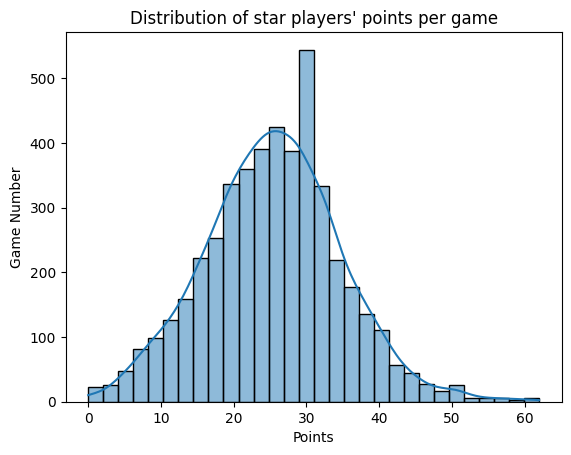

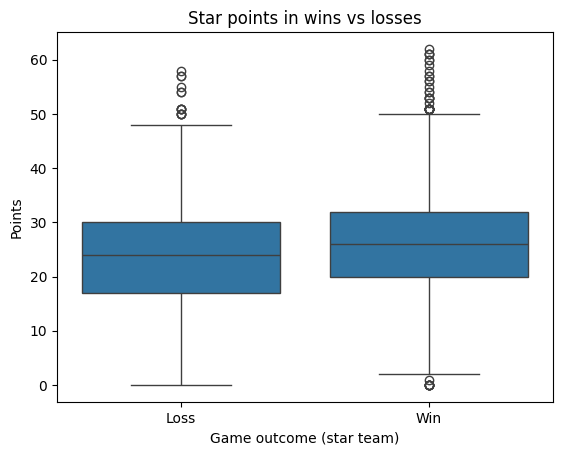

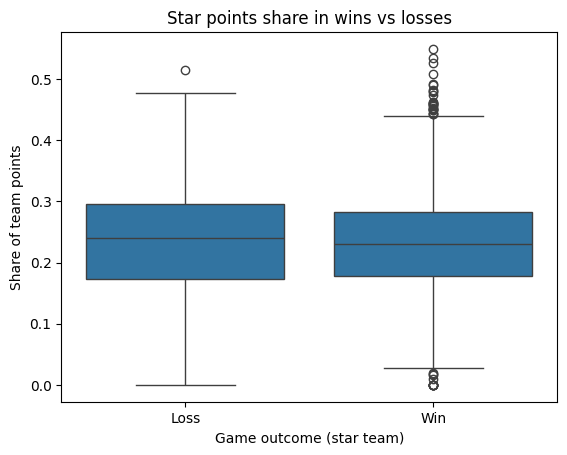

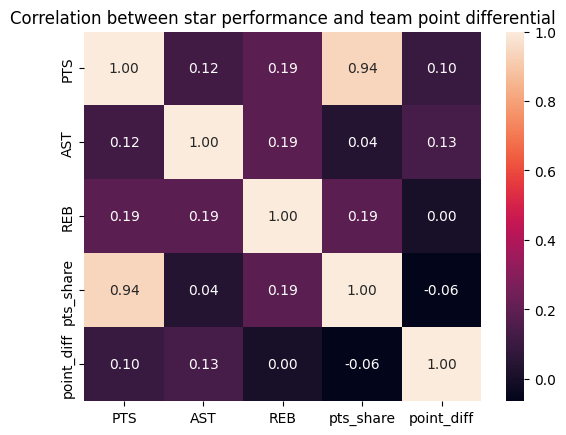

In [15]:
plt.figure()
sns.histplot(star_games['PTS'], bins=30, kde=True)
plt.title("Distribution of star players' points per game")
plt.xlabel("Points")
plt.ylabel("Game Number")
plt.show()

plt.figure()
sns.boxplot(x='star_team_win', y='PTS', data=star_games)
plt.xticks([0, 1], ['Loss', 'Win'])
plt.title("Star points in wins vs losses")
plt.xlabel("Game outcome (star team)")
plt.ylabel("Points")
plt.show()

plt.figure()
sns.boxplot(x='star_team_win', y='pts_share', data=star_games)
plt.xticks([0, 1], ['Loss', 'Win'])
plt.title("Star points share in wins vs losses")
plt.xlabel("Game outcome (star team)")
plt.ylabel("Share of team points")
plt.show()


corr_cols = ['PTS', 'AST', 'REB', 'pts_share', 'point_diff']
corr_matrix = star_games[corr_cols].corr()

plt.figure()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation between star performance and team point differential")
plt.show()


### 9. Define high-scoring games relative to each star

Here I create a new Boolean variable `high_pts`:

- For each player separately, I compute their median points per game.  
- A game is labeled `high_pts = True` if the star’s points in that game are above that player’s own median; otherwise it is `False`.

This creates a simple way to classify games into “high scoring” vs. “normal/low scoring” relative to each star’s usual performance, which is needed for the first hypothesis test.


In [16]:
star_games['high_pts'] = star_games.groupby('PLAYER_NAME')['PTS'] \
                                   .transform(lambda x: x > x.median())

star_games[['PLAYER_NAME', 'PTS', 'high_pts']].head()


,PLAYER_NAME,PTS,high_pts
0,James Harden,15.0,False
1,Kevin Durant,23.0,False
2,LeBron James,31.0,True
3,James Harden,14.0,False
4,Kevin Durant,43.0,True


### 10. Hypothesis Test 1 – Win rate when the star scores high vs low

In this cell I test whether teams win more often when their star has a high-scoring game.

Steps:

1. Split the data into two groups: games with `high_pts = True` and games with `high_pts = False`.
2. Compute the win rate (`star_team_win` mean) in each group.
3. Perform a two-proportion z-test:
   - Null hypothesis \(H_0\): the win probability is the same in both groups \(p_{high} = p_{low}\).
   - Alternative hypothesis \(H_1\): the win probability is higher when the star scores above their median \(p_high} > p_{low}\).
4. Calculate the z-statistic and one-sided p-value.

**Numerical results**

- Win rate when the star scores **high**: ≈ **0.691** (69.1%)  
- Win rate when the star scores **low**: ≈ **0.622** (62.2%)  
- Difference in win rate: ≈ **6.9 percentage points**  
- z-statistic: ≈ **4.89**  
- One-sided p-value: ≈ **4.96 × 10⁻⁷**

Because the p-value is far below 0.05, I reject \(H_0\) and conclude that teams win **significantly more often** when their star scores above their usual (median) point level.


In [17]:
high_group = star_games[star_games['high_pts']]
low_group  = star_games[~star_games['high_pts']]

wins_high = high_group['star_team_win'].sum()
n_high    = high_group.shape[0]

wins_low  = low_group['star_team_win'].sum()
n_low     = low_group.shape[0]

p_high = wins_high / n_high
p_low  = wins_low / n_low

print("Win rate when star scores high:", p_high)
print("Win rate when star scores low :", p_low)

p_pool = (wins_high + wins_low) / (n_high + n_low)
se = np.sqrt(p_pool * (1 - p_pool) * (1/n_high + 1/n_low))
z_stat = (p_high - p_low) / se

p_value = 1 - stats.norm.cdf(z_stat)

z_stat, p_value


Win rate when star scores high: 0.690712353471596
Win rate when star scores low : 0.6224322103533279


(np.float64(4.893071795309229), np.float64(4.963708525318467e-07))

### 11. Hypothesis Test 2 – Do stars score more in wins than in losses?

This cell tests whether star players score more points in games their team wins than in games their team loses.

Steps:

1. Split star games into two groups based on `star_team_win` (wins vs losses).
2. Compute the average points in each group.
3. Apply a Welch two-sample t-test:
   - Null hypothesis \(H_0\): mean points in wins = mean points in losses.
   - Alternative hypothesis \(H_1\): mean points are higher in wins.
4. Convert the two-sided p-value to a one-sided p-value for the directional hypothesis.

**Numerical results**

- Mean points in **wins**: ≈ **26.28**  
- Mean points in **losses**: ≈ **23.89**  
- Difference in means: ≈ **2.39 points**  
- t-statistic: ≈ **8.25**  
- One-sided p-value: ≈ **1.21 × 10⁻¹⁶**

The p-value is extremely small, so I reject \(H_0\) and conclude that star players score **significantly more points** in games their team wins than in games their team loses. On average, they score about 2–2.5 extra points in wins.


In [18]:
pts_win  = star_games.loc[star_games['star_team_win'] == 1, 'PTS']
pts_loss = star_games.loc[star_games['star_team_win'] == 0, 'PTS']

print("Mean PTS (wins) :", pts_win.mean())
print("Mean PTS (losses):", pts_loss.mean())

t_stat, p_val_two_sided = stats.ttest_ind(pts_win, pts_loss, equal_var=False, nan_policy='omit')

p_val_one_sided = p_val_two_sided / 2 if t_stat > 0 else 1 - p_val_two_sided / 2
t_stat, p_val_one_sided


Mean PTS (wins) : 26.27765014768625
Mean PTS (losses): 23.889719626168223


(np.float64(8.243533937572613), np.float64(1.2056835556364593e-16))